# Complementary filter

The basic principle behind the complementary filter is to take advantage of the strengths of two different sensors and mitigate their weaknesses by combining their outputs in a complementary manner. For instance, consider the common application of estimating the orientation of a flying drone using data from an accelerometer and a gyroscope:
Accelerometers measure linear acceleration, including gravity, which can be used to determine the inclination of the device relative to the Earth. However, they are prone to noise from vibration and sudden movements, and cannot track orientation accurately without a reference to gravity.
Gyroscopes measure the rate of rotation around an axis and can provide smooth and responsive measurements of angular motion. However, they suffer from drift over time due to integration of angular velocity to calculate orientation, leading to increasing error in the absence of a corrective reference.

The complementary filter operates by mathematically combining the accelerometer and gyroscope outputs to produce a single, more accurate estimation of orientation. The filter is called "complementary" because it essentially blends the high-frequency component (where the gyroscope excels) with the low-frequency component (where the accelerometer data is more reliable), thus complementing the strengths of each sensor.

A simple implementation of the complementary filter can be described by the following equation, which computes the estimated orientation as a weighted sum of the gyroscope-based orientation  and the accelerometer-based orientation:
$$
\hat{\theta} = \alpha \cdot (\hat{\theta} + \theta_{gyro} \cdot \Delta t) + (1 - \alpha) \cdot \theta_{accel}
$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from test_data.import_data import get_data, get_gt
from ahrs import filters
from ahrs.common import Quaternion
from ahrs.common.orientation import acc2q

gain = 0.9
sample_rate = 1000

complementary = filters.complementary.Complementary(frequency=sample_rate, gain=gain)
initial_pos_estimator = filters.Tilt()

In [2]:
[acc, gyro, mag] = get_data()

estimations = np.empty((len(acc), 4))
estimations[0] = initial_pos_estimator.estimate(acc=acc[0], mag=mag[0]) 

for i in range(1, len(acc)):
    estimations[i] = complementary.update(estimations[i-1], acc=acc[i], gyr=gyro[i], mag=mag[i])

In [3]:
def clamp_to_360(x):
    x = np.mod(x, 360)
    return x

In [4]:
from utils import quaternion_to_euler
phi_hat, theta_hat, psi_hat = quaternion_to_euler(estimations)

phi_hat = clamp_to_360(phi_hat)
theta_hat = clamp_to_360(theta_hat)
psi_hat = clamp_to_360(psi_hat + 90) # todo: mind the + 90 here

In [5]:
phi, theta, psi = quaternion_to_euler(get_gt())

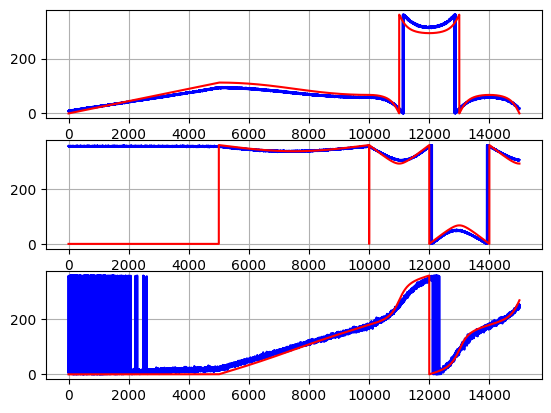

In [6]:
%matplotlib inline

plt.subplot(3, 1, 1)
plt.plot(phi_hat, 'b')
plt.plot(phi, 'r')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(theta_hat, 'b')
plt.plot(theta, 'r')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(psi_hat, 'b')
plt.plot(psi, 'r')
plt.grid()

plt.show()


In [7]:
print(phi_hat)

[ 9.05561745 10.06708403  9.0364578  ... 15.42374287 18.09582199
 19.67426439]


In [8]:
estimations

array([[ 0.99453314,  0.07688306, -0.03390235, -0.06199569],
       [ 0.74728196,  0.04579216, -0.08057993, -0.65801187],
       [ 0.64676465,  0.02971901, -0.07807316, -0.75810082],
       ...,
       [ 0.0816453 ,  0.47400559,  0.04198979,  0.87572233],
       [ 0.12857803,  0.47806376,  0.03100355,  0.86830957],
       [ 0.14014147,  0.47340563,  0.03662162,  0.86885346]])